# Wasserstein Gan (w & w/o gradient penalty)

This is an attempt to re-implement the paper WGAN & WGAN-GP

Paper: https://arxiv.org/pdf/1701.07875v3.pdf, https://arxiv.org/pdf/1704.00028v3.pdf

Other Resources: 
* https://github.com/igul222/improved_wgan_training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
img_size = 28
channels = 1
batch_size = 256
latent_dim = 100
(x_train, x_label), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
def load_dataset(data, labels, c_num = -1):
        
        if c_num != -1:
            data = data[np.where(x_label == c_num)]
            
        x_train = ((data/255)*2)-1
        x_train = x_train.reshape(x_train.shape[0], img_size, img_size, channels)
        x_train = tf.cast(x_train, tf.float32)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
        
        return x_train
    
data = load_dataset(x_train, x_label, 4)

In [4]:
class ClipConstraint(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return tf.keras.backend.clip(weights, self.clip_value[0], self.clip_value[1])

In [5]:
def generator(dim = latent_dim):
    init = tf.random_normal_initializer(0.0, 0.02)
    inp = tf.keras.layers.Input(shape = (dim), dtype = tf.float32, name = 'Generator_input')
    
    x = tf.keras.layers.Dense(7 * 7 *128, kernel_initializer = init)(inp)
    x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)


    x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2, 2), 
                                        padding = 'same', kernel_initializer = init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

    x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2, 2), 
                                        padding = 'same', kernel_initializer = init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

    x = tf.keras.layers.Conv2D(filters = 1, kernel_size = (7, 7), strides = (1, 1), padding = 'same', 
               kernel_initializer = init)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    
    return tf.keras.models.Model(inp, x, name = 'Generator')

In [6]:
def critic(img_size = img_size, channels = channels, clip_range = None):
    init = tf.random_normal_initializer(0.0, 1.0)
    inp = tf.keras.layers.Input(shape = (img_size, img_size, channels), dtype = tf.float32, name = 'Critic_input')

    if clip_range is not None:
        clip = ClipConstraint(clip_range)
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', 
                                   kernel_initializer = init, kernel_constraint = clip)(inp)
    else:
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', 
                                   kernel_initializer = init)(inp)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

    if clip_range is not None:
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', 
                                   kernel_initializer = init, kernel_constraint = clip)(x)
    else:
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', 
                                   kernel_initializer = init)(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 1)(x)
    
    return tf.keras.models.Model(inp, x, name = 'Critic')

In [18]:
def generator_loss(crit_gen_out):
    return -tf.math.reduce_mean(crit_gen_out)

def gradient_penalty(crit, real, gen, gp_weight = 10):
    
    epsilon = tf.random.uniform(shape = (real.shape[0], 1, 1, 1), minval = 0.0, maxval = 1.0)
    interpolated = ((1 - epsilon) * real) + (epsilon * gen)
    
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        out = crit(interpolated)
        
    grads = gp_tape.gradient(out, [interpolated])[0]
    norm = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(grads), axis = [1, 2, 3], keepdims = True))
    gp = tf.math.reduce_mean(tf.square(norm - 1))
    return gp * gp_weight

def critic_loss(crit_real_out, crit_gen_out):
    return tf.math.reduce_mean(crit_gen_out) - tf.math.reduce_mean(crit_real_out)

In [19]:
crit_opt_gp = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0, beta_2 = 0.9)
crit_opt = tf.keras.optimizers.RMSprop(learning_rate = 5e-5)

gen_opt_gp = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0, beta_2 = 0.9)
gen_opt = tf.keras.optimizers.RMSprop(learning_rate = 5e-5)

In [20]:
@tf.function
def train_step(img, n_critics = 5, apply_gp = True):
    
    noise = tf.random.normal((img.shape[0], latent_dim))
    for _ in range(n_critics):
        with tf.GradientTape() as crit_tape:
            gen_out = gen(noise, training = True)
            
            crit_real_out = crit(img, training = True)
            crit_gen_out  = crit(gen_out, training = True)
            
            crit_loss = critic_loss(crit_real_out, crit_gen_out)
            if apply_gp:
                crit_loss += gradient_penalty(crit, img, gen_out)
                
        crit_grads = crit_tape.gradient(crit_loss, crit.trainable_variables)
        if apply_gp:
            crit_opt_gp.apply_gradients(zip(crit_grads, crit.trainable_variables))
        else:
            crit_opt.apply_gradients(zip(crit_grads, crit.trainable_variables))
            
    
    with tf.GradientTape() as gen_tape:
        gen_out = gen(noise, training = True)
        crit_gen_out = crit(gen_out, training = True)
        gen_loss = generator_loss(crit_gen_out)
        
    gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
    if apply_gp:
        gen_opt_gp.apply_gradients(zip(gen_grads, gen.trainable_variables))
    else:
        gen_opt.apply_gradients(zip(gen_grads, gen.trainable_variables))
        
    return crit_loss, gen_loss

In [21]:
def train(data, epochs = 3):
    for e in range(epochs):
        print(f'Epoch {e} Starts')
        for img in data:
            crit_loss, gen_loss = train_step(img, n_critics = 5, apply_gp = True)
            print('.', end='')

        print(f'\nGenerator Loss : {gen_loss} \t Critic Loss : {crit_loss}')
        print(f'Epoch {e} Ends\n\n\n')

In [22]:
gen = generator()
# crit = critic(clip_range = (-0.01, 0.01))
crit = critic(clip_range = None)
train(data, epochs = 10)

Epoch 0 Starts
.......................
Generator Loss : -5.056664943695068 	 Critic Loss : 5.805514335632324
Epoch 0 Ends



Epoch 1 Starts
.......................
Generator Loss : -9.912121772766113 	 Critic Loss : 5.832494735717773
Epoch 1 Ends



Epoch 2 Starts
.......................
Generator Loss : -12.92257022857666 	 Critic Loss : 8.173518180847168
Epoch 2 Ends



Epoch 3 Starts
.......................
Generator Loss : -10.856505393981934 	 Critic Loss : 8.49040412902832
Epoch 3 Ends



Epoch 4 Starts
.......................
Generator Loss : -7.461540699005127 	 Critic Loss : 7.467710971832275
Epoch 4 Ends



Epoch 5 Starts
.......................
Generator Loss : -8.229317665100098 	 Critic Loss : 7.972630977630615
Epoch 5 Ends



Epoch 6 Starts
.......................
Generator Loss : -9.519908905029297 	 Critic Loss : 7.111380100250244
Epoch 6 Ends



Epoch 7 Starts
.......................
Generator Loss : -10.872139930725098 	 Critic Loss : 7.150426864624023
Epoch 7 Ends




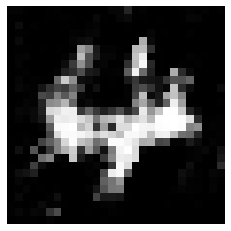

In [27]:
plt.imshow(((gen(tf.random.normal((1, 100)))[0]+1)*127.5).numpy()\
           .astype('uint8'), cmap = 'binary_r')
plt.axis('off')
plt.show()